## Задание 1.
Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories). Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu
import urllib
from urllib.parse import urlencode

import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
from scipy import stats
from sklearn.cluster import KMeans
import plotly.express as px

## Фаза скачивания и предобработки данных

In [2]:
#скачивание active_users – информация о пользователях, которые посещали приложение во время эксперимента.
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
base_url
public_key = 'https://disk.yandex.ru/d/B4QnY5D5EtKa-A'  # ссылка на  active_users
# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [3]:
users_df = pd.read_csv(download_url, encoding='Windows-1251', sep=',')
users_df.head(5)

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male


In [4]:
#проверим данные. есть ли ошибки в логах, пустые данные

In [5]:
users_df.country.unique()

array(['Russia', 'Sweden'], dtype=object)

In [6]:
users_df.platform.unique()

array(['ios', 'android'], dtype=object)

In [7]:
users_df.isna().sum()

user_id     0
country     0
platform    0
sex         0
dtype: int64

In [8]:
users_df.dtypes

user_id      int64
country     object
platform    object
sex         object
dtype: object

In [9]:
users_df.describe(include='object')

,country,platform,sex
count,8341,8341,8341
unique,2,2,2
top,Russia,android,male
freq,5407,4621,4196


In [10]:
#скачаем второй датафрейм и посмотрим на данные

In [11]:
#скачивание purchases – данные о транзакциях (оплатах) пользователей приложения во время эксперимента 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
base_url
public_key = 'https://disk.yandex.ru/d/AmucCdboEaowhA'  # ссылка на  active_users
# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [12]:
purchases_df = pd.read_csv(download_url, encoding='Windows-1251', sep=',')
purchases_df.head(5)

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0


In [13]:
#проверим данные на NaN и тип столбцов

In [14]:
purchases_df.isna().sum()

user_id    0
revenue    0
dtype: int64

In [15]:
purchases_df.dtypes

user_id      int64
revenue    float64
dtype: object

In [16]:
purchases_df.shape

(541, 2)

In [17]:
#определим конверсию в покупку, объединив сперва два предыдущих датафрейма

In [18]:
users_purchase=users_df.merge(purchases_df, how='left', on='user_id')
users_purchase.head()

,user_id,country,platform,sex,revenue
0,8029,Russia,ios,male,NaN
1,1735,Sweden,ios,male,NaN
2,7697,Russia,android,male,NaN
3,1421,Sweden,android,female,NaN
4,1704,Russia,ios,male,NaN


In [19]:
#создадим колонку для подсчета конверсии в дальнейшем
users_purchase['conv_value']=users_purchase.revenue.isna()
users_purchase['conv_value']=users_purchase['conv_value'].replace({True: 0, False: 1})
users_purchase

,user_id,country,platform,sex,revenue,conv_value
0,8029,Russia,ios,male,NaN,0
1,1735,Sweden,ios,male,NaN,0
2,7697,Russia,android,male,NaN,0
3,1421,Sweden,android,female,NaN,0
4,1704,Russia,ios,male,NaN,0
...,...,...,...,...,...,...
8336,2417,Sweden,ios,female,NaN,0
8337,3755,Russia,ios,male,590.0,1
8338,4594,Sweden,android,female,NaN,0
8339,7430,Sweden,ios,female,NaN,0


In [20]:
#теперь выведем 3й датафрейм, посмотрим на него и проверим как распределены пользователи в группах А и B

In [21]:
#скачивание groups – разбивка пользователей на контрольную (А) и тестовую (В) группы. 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
base_url
public_key = 'https://disk.yandex.ru/d/jP_BAw_oxS3law'  # ссылка на  active_users
# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [22]:
groups_df = pd.read_csv(download_url, encoding='Windows-1251', sep=',')
groups_df.head(5)

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


In [23]:
groups_df.shape

(74576, 2)

In [24]:
groups_df.user_id.nunique()

74576

In [25]:
groups_df.describe(include='object')

,group
count,74576
unique,2
top,B
freq,59883


In [26]:
#соотенесем распределенные id пользователей в рамках A/B сплитования к заходишвим во время эксперимента. Т.е все ли user_id входят в А или B группы
#другими словами объединим новый датафрейм с уже комбинированным
users_purchase_ab=users_purchase.merge(groups_df, how='left', on='user_id')
users_purchase_ab.head()

,user_id,country,platform,sex,revenue,conv_value,group
0,8029,Russia,ios,male,NaN,0,B
1,1735,Sweden,ios,male,NaN,0,B
2,7697,Russia,android,male,NaN,0,B
3,1421,Sweden,android,female,NaN,0,B
4,1704,Russia,ios,male,NaN,0,B


In [27]:
users_purchase_ab.group.unique()

array(['B', 'A'], dtype=object)

In [28]:
#получается все пользователи заходившие на сайт попали либо в контрольную А, либо тестовые B группы

In [29]:
#при этом подавляющее большинство пользователей заходивших на сайт попало в B группу
users_purchase_ab.group.value_counts(normalize=True).mul(100)

B    81.560964
A    18.439036
Name: group, dtype: float64

In [30]:
users_purchase_ab.group.value_counts()

B    6803
A    1538
Name: group, dtype: int64

In [31]:
#сохраним удобный датафрейм для Задания 2
users_purchase_ab.to_csv('users_purchase_group.csv')

## Анализ тенденций в контрольной группе

In [32]:
#оценим на первый взгляд тенденции по средним чекам в группе А
users_purchase_ab[users_purchase_ab.group=='A'].pivot_table(index=['platform','sex'], columns='country', values='revenue', aggfunc='mean')

country              Russia       Sweden
platform sex                            
android  female  843.636364   690.833333
         male    547.750000  1577.928571
ios      female  892.923077   953.428571
         male    921.545455   660.125000

Первые выводы о среднем чеке по группе А:
1)женщины из России имеют лишь чуть больший чек на платформе ios нежели на android, тогда как мужчины уже значительно более высокий на ios. В целом для мужчин и женщин, более высокий средний чек в России будет на платформе ios. 
2)женщины из Швеции имеют значительно более высокий средний чек на ios, мужчины же наоборот - значительно более высокий на android. В целом для мужчин и женщин, более высокий средний чек в Швеции будет на платформе android.

In [33]:
#оценим на первый взгляд конверсию в покупку шаблонов в группе А
users_purchase_ab[users_purchase_ab.group=='A'].pivot_table(index=['platform','sex'], columns='country', values='conv_value', aggfunc='mean')

country            Russia    Sweden
platform sex                       
android  female  0.041199  0.037037
         male    0.032922  0.086420
ios      female  0.074713  0.046667
         male    0.047619  0.053691

Первые выводы о конвертации в покупку по группе А:
1)женщины из России намного лучше конвертируются в покупку на платформе ios нежели на android, что так же справделиво и для мужчин. В целом для мужчин и женщин, конвертация по аудитории в России однозначно выше на ios. 
2)женщины из Швеции лучше конвертируются в покупку на платформе ios нежели на android, мужчины же наоборот - значительно лучше на android. В целом для мужчин и женщин, конвертация по аудитории в Швеции лучше на платформе android.

In [34]:
#средние чеки и конвертации это хорошо, но для бизнеса огромную роль играет выручка. 
#Попробуем оценить выручку для группы А по странам, платформам и полу и понять, какая аудитория для нас наиболее ценна

In [35]:
users_purchase_ab[users_purchase_ab.group=='A'].pivot_table(index=['platform','sex'], columns='country', values='revenue', aggfunc='sum')

country           Russia   Sweden
platform sex                     
android  female   9280.0   4145.0
         male     4382.0  22091.0
ios      female  11608.0   6674.0
         male    10137.0   5281.0

In [36]:
users_purchase_ab[users_purchase_ab.group=='A'].groupby('platform').agg({'revenue':'sum'})

,revenue
platform,
android,39898.0
ios,33700.0


In [37]:
users_purchase_ab[users_purchase_ab.group=='A'].groupby('sex').agg({'revenue':'sum'})

,revenue
sex,
female,31707.0
male,41891.0


In [38]:
users_purchase_ab[users_purchase_ab.group=='A'].groupby('country').agg({'revenue':'sum'})

,revenue
country,
Russia,35407.0
Sweden,38191.0


Первые выводы о выручке по группе А:
1)Важная статья доходов это пользователи ios в России (мужчины и женщины), а также пользователи android в Швеции (мужчины тратят во много раз больше женщин)
2)Мужчины пользователи android в России, женщины пользователи android и ios в Швеции, а так же мужчины пользователи ios в Швеции принесли компании значительно меньше денег, нежели другие типы пользователей android и ios в упомнятных странах.

## Проверка контрольной и тестовой группы на репрезентативность

In [39]:
#распределение по странам группы А и B
print('by country\n A:\n',users_purchase_ab[users_purchase_ab.group=='A'].country.value_counts(normalize=True).mul(100))
print('B:\n',users_purchase_ab[users_purchase_ab.group=='B'].country.value_counts(normalize=True).mul(100))

by country
 A:
 Russia    59.492848
Sweden    40.507152
Name: country, dtype: float64
B:
 Russia    66.029693
Sweden    33.970307
Name: country, dtype: float64


In [40]:
#распределение по платформам группы А и B
print('by platform\n A:\n',users_purchase_ab[users_purchase_ab.group=='A'].platform.value_counts(normalize=True).mul(100))
print('B:\n',users_purchase_ab[users_purchase_ab.group=='B'].platform.value_counts(normalize=True).mul(100))

by platform
 A:
 android    54.226268
ios        45.773732
Name: platform, dtype: float64
B:
 android    55.666618
ios        44.333382
Name: platform, dtype: float64


In [41]:
#распределение по полу группы А и B
print('by sex\n A:\n',users_purchase_ab[users_purchase_ab.group=='A'].sex.value_counts(normalize=True).mul(100))
print('B:\n',users_purchase_ab[users_purchase_ab.group=='B'].sex.value_counts(normalize=True).mul(100))

by sex
 A:
 male      51.040312
female    48.959688
Name: sex, dtype: float64
B:
 male      50.139644
female    49.860356
Name: sex, dtype: float64


In [42]:
#Как мы видим, по критерию страны выборки A и B значительно отличаются по количеству участвующих user_id.
#Однако стоит проверить, насколько коррелирует конкретная страна с конверсией в покупку и средней суммой. 

In [43]:
#конверсия для группы А
u_p_mean_а=users_purchase_ab[users_purchase_ab.group=='A'].groupby(['country'],as_index=False).agg({'conv_value':'mean'})
u_p_mean_а

,country,conv_value
0,Russia,0.046995
1,Sweden,0.056180


In [44]:
#средний чек приобретенных шаблонов группы А
u_p_sum_а=users_purchase_ab[(users_purchase_ab.group=='A') & (users_purchase_ab.revenue >0)].groupby(['country'],as_index=False).agg({'revenue':'mean'})
u_p_sum_а

,country,revenue
0,Russia,823.418605
1,Sweden,1091.171429


На основании проделанного анализа можно сделать вывод - наблюдаемый дисбаланс по странам в тестовой и контрольной выборках способен исказить картину А/B теста для конверсий и среднего чека, поскольку существует значительная разница для конверсий в Швеции и России, и существует разница в средних чеках этих стран. 

В целом, в решении проблемы репрезентативности выборок может помочь увеличение времени проведения A/B теста, улучшенная настройка и проверка системы сплитования в рамках А/A теста. В случаях же верной настройки системы сплитования, проблема может лежать в независящих от нас причинах, которые так же полезно обнаружить (например временный сбой работы приложения для пользователей Швеции)

В рамках нашего задания попробую применить метод случайной стратификации для исправления дисбаланса в группе B, ориентируясь при этом на пропорции по странам в группе А (группа А может при этом не отражать реальное положение дел в ГС, но в данной задаче опираться больше не на что, и пускай группа А отражает все пропорции ГС). При этом для надежности создам 3 случайных стратифицованных датафрейма, применя стат методы с каждым из них. В случае если отличия для каждого стратифицрованного датафрейма получаются стат значимы, то с заданной вероятностью считаем эффект от новой модели оплаты коллекций шаблонов действенным.

### Сэмплирование контрольной группы B для соответствия репрезентативным пропорциям в группе А

In [50]:
#отфильтруем для удобства всех пользователей попавших в группы А и В
df_country_A=users_purchase_ab[users_purchase_ab.group=='A']
df_country_B=users_purchase_ab[users_purchase_ab.group=='B']

In [54]:
#зададим стратифицирующую функцию
def stratify_data(df_data, stratify_column_name, stratify_values, stratify_proportions, random_state=None):
  
    df_stratified = pd.DataFrame(columns = df_data.columns) # Создаем пустой датафрейм с колонками как в df_data

    pos = -1
    for i in range(len(stratify_values)): # иттерируемся по значениям категорий стратификации
        pos += 1
        if pos == len(stratify_values) - 1: 
            ratio_len = len(df_country_A) - len(df_stratified) # Для последней иттерации задаем размер датафрейма
        else:
            ratio_len = int(len(df_country_A) * stratify_proportions[i]) # вычисляем количество строк для соответствия требуемой пропорции

        df_filtered = df_data[df_data[stratify_column_name] ==stratify_values[i]] # Фильтруем данные на основе выбранных stratify value
        df_temp = df_filtered.sample(replace=False, n=ratio_len, random_state=random_state) # Сэмплируем фильтрованные данные на основании заданных пропорций
        
        
        
        df_stratified = pd.concat([df_stratified, df_temp]) # Добавляем sampled / stratified datasets вместе для получения финального датафрейма
    return df_stratified # возвращаем стратифицированный датафрейм с нужными пропорциями категориальных параметров
    

Для данного сэмплирования возможно было выбрать такой вариант - сгенерировать дубликаты пользователей для соответствия нужныи пропорциям, и оставить все варианты уникальных пользователей из контрольной группы. Я же выбрал другой вариант - сузить тестовую выборку до размеров контрольной, создав нужные пропорции, но и удалив при этом значительную часть пользователей.

In [55]:
stratify_values = ['Russia','Sweden'] #зададим значения категориальных параметров, по которым будем создавать нужны пропорции
stratify_proportions = [0.595,0.405] #зададим пропорции, похоожие на те что в группе А

In [56]:
#стратифицированная выборка №1
stratified_B_1= stratify_data(df_country_B, 'country', stratify_values, stratify_proportions, random_state=10) #применим заданную ранее функцию
stratified_B_1

,user_id,country,platform,sex,revenue,conv_value,group
4257,6302,Russia,ios,male,NaN,0,B
5863,3514,Russia,android,female,NaN,0,B
1226,2885,Russia,ios,female,NaN,0,B
3573,6538,Russia,android,male,NaN,0,B
4041,4505,Russia,android,male,NaN,0,B
...,...,...,...,...,...,...,...
4764,3625,Sweden,android,female,NaN,0,B
3061,4721,Sweden,ios,male,NaN,0,B
2849,3394,Sweden,android,female,NaN,0,B
5893,2331,Sweden,ios,female,NaN,0,B


In [57]:
#стратифицированная выборка №2
stratified_B_2= stratify_data(df_country_B, 'country', stratify_values, stratify_proportions, random_state=20) #применим заданную ранее функцию
stratified_B_2

,user_id,country,platform,sex,revenue,conv_value,group
2404,154,Russia,android,male,NaN,0,B
1535,3722,Russia,android,male,NaN,0,B
3511,4845,Russia,android,female,NaN,0,B
2429,5128,Russia,android,male,NaN,0,B
5952,181,Russia,android,male,NaN,0,B
...,...,...,...,...,...,...,...
6161,8323,Sweden,android,female,NaN,0,B
5811,2513,Sweden,ios,female,NaN,0,B
2139,6068,Sweden,android,male,NaN,0,B
6791,5397,Sweden,ios,female,NaN,0,B


In [58]:
#стратифицированная выборка №3
stratified_B_3= stratify_data(df_country_B, 'country', stratify_values, stratify_proportions, random_state=30) #применим заданную ранее функцию
stratified_B_3

,user_id,country,platform,sex,revenue,conv_value,group
1687,7994,Russia,android,female,1991.0,1,B
546,328,Russia,android,female,NaN,0,B
5917,1947,Russia,android,female,NaN,0,B
711,6373,Russia,android,male,NaN,0,B
7701,5472,Russia,android,female,NaN,0,B
...,...,...,...,...,...,...,...
2590,3284,Sweden,android,female,NaN,0,B
6262,7669,Sweden,ios,male,NaN,0,B
1159,3008,Sweden,android,female,NaN,0,B
8042,1529,Sweden,android,male,NaN,0,B


In [63]:
stratified_B_1['conv_value']=stratified_B_1['conv_value'].astype(int)
stratified_B_2['conv_value']=stratified_B_2['conv_value'].astype(int)
stratified_B_3['conv_value']=stratified_B_3['conv_value'].astype(int)

In [64]:
#сравним новые стратифицированные выборки B с выборкой А по странам
print('Grouped by countries\n stratified B_1:\n',
      stratified_B_1.country.value_counts(normalize=True).mul(100),
      '\n',
      'stratified B_2:\n',
      stratified_B_2.country.value_counts(normalize=True).mul(100),
      '\n',
      'stratified B_3:\n',
      stratified_B_3.country.value_counts(normalize=True).mul(100),
      '\n',
      'A:\n',
      users_purchase_ab[users_purchase_ab.group=='A'].country.value_counts(normalize=True).mul(100))

Grouped by countries
 stratified B_1:
 Russia    59.492848
Sweden    40.507152
Name: country, dtype: float64 
 stratified B_2:
 Russia    59.492848
Sweden    40.507152
Name: country, dtype: float64 
 stratified B_3:
 Russia    59.492848
Sweden    40.507152
Name: country, dtype: float64 
 A:
 Russia    59.492848
Sweden    40.507152
Name: country, dtype: float64


In [65]:
#сравним новую стратифицированную выборку B с выборкой А по платформам
print('Grouped by platform\n stratified B_1:\n',
      stratified_B_1.platform.value_counts(normalize=True).mul(100),
      '\n',
      'stratified B_2:\n',
      stratified_B_2.platform.value_counts(normalize=True).mul(100),
      '\n',
      'stratified B_3:\n',
      stratified_B_3.platform.value_counts(normalize=True).mul(100),
      '\n',
      'A:\n',
      users_purchase_ab[users_purchase_ab.group=='A'].platform.value_counts(normalize=True).mul(100))

Grouped by platform
 stratified B_1:
 android    55.26658
ios        44.73342
Name: platform, dtype: float64 
 stratified B_2:
 android    54.356307
ios        45.643693
Name: platform, dtype: float64 
 stratified B_3:
 android    55.721717
ios        44.278283
Name: platform, dtype: float64 
 A:
 android    54.226268
ios        45.773732
Name: platform, dtype: float64


In [66]:
#сравним новую стратифицированную выборку B с выборкой А по полу
print('Grouped by sex\n stratified B_1:\n',
    stratified_B_1.sex.value_counts(normalize=True).mul(100),
        '\n',
      'stratified B_2:\n',
      stratified_B_2.sex.value_counts(normalize=True).mul(100),
        '\n',
      'stratified B_3:\n',
      stratified_B_3.sex.value_counts(normalize=True).mul(100),
        '\n',
      'A:\n',
      users_purchase_ab[users_purchase_ab.group=='A'].sex.value_counts(normalize=True).mul(100))

Grouped by sex
 stratified B_1:
 female    51.755527
male      48.244473
Name: sex, dtype: float64 
 stratified B_2:
 male      51.30039
female    48.69961
Name: sex, dtype: float64 
 stratified B_3:
 male      51.560468
female    48.439532
Name: sex, dtype: float64 
 A:
 male      51.040312
female    48.959688
Name: sex, dtype: float64


Получившиеся выборки выглядят более репрезентативно, нежели изначальная тестовая выборка B. 

## Предварительная оценка изменений средних чеков и конверсии в покупку 

In [67]:
#объединим полученные сэмплированные выборки с контрольной А

In [68]:
df_AB_1=pd.concat([stratified_B_1, users_purchase_ab[users_purchase_ab.group=='A']])
df_AB_2=pd.concat([stratified_B_2, users_purchase_ab[users_purchase_ab.group=='A']])
df_AB_3=pd.concat([stratified_B_3, users_purchase_ab[users_purchase_ab.group=='A']])

In [69]:
#изменим формат столба conv_value для дальнейшей работы
df_AB_1['conv_value']=df_AB_1['conv_value'].astype(int)
df_AB_2['conv_value']=df_AB_2['conv_value'].astype(int)
df_AB_3['conv_value']=df_AB_3['conv_value'].astype(int)

В рамках данной задачи я предполагаю возможность введения новой системы оплаты для конкретной категории пользователей в рамках страны, или платформы, или их определенной комбинации. 

Категорию sex не будем рассматривать в рамках комбинирования, поскольку на мой взгляд не правильно выкатывать мальчикам одну систему оплаты, а девочкам другую в рамках одной страны или платформы. Это может вызвать неудобные гендерные вопросы.

In [70]:
#посмотрим на средние чеки для контрольной и тестовых групп в рамках сегрегирования по платформе и стране.

In [71]:
df_AB_1.pivot_table(index=['country','platform'], columns=['group'], values='revenue', aggfunc='mean')

group                       A            B
country platform                          
Russia  android    719.052632  1357.428571
        ios        906.041667   831.933333
Sweden  android   1311.800000   984.800000
        ios        797.000000  1653.250000

In [72]:
df_AB_2.pivot_table(index=['country','platform'], columns=['group'], values='revenue', aggfunc='mean')

group                       A            B
country platform                          
Russia  android    719.052632  1392.954545
        ios        906.041667  1037.269231
Sweden  android   1311.800000   881.214286
        ios        797.000000  1489.733333

In [73]:
df_AB_3.pivot_table(index=['country','platform'], columns=['group'], values='revenue', aggfunc='mean')

group                       A            B
country platform                          
Russia  android    719.052632  1329.851852
        ios        906.041667  1022.240000
Sweden  android   1311.800000   910.111111
        ios        797.000000  1201.052632

**Предварительные выводы о росте среднего чека**:

1) явный прирост среднего чека с новой системой оплаты шаблонов замечен в Russia на платформе android и в Sweden на ios. Стоит провести оценку стат значимости роста для этих категорий.

2) падение суммы среднего чека замечено в Sweden на платформе android. Однозначно рисковая категория пользователей для введения новой системы оплаты шаблонов.

3) пользователи в Russia на ios под вопросом. На основании данных тестовых выборок нельзя однозачно сказать о тенденциях среднего чека для данной категории.

In [74]:
#теперь посмотрим на конверсию в покупку шаблонов для контрольной и тестовых групп в рамках сегрегирования по платформе и стране.

In [75]:
df_AB_1.pivot_table(index=['country','platform'], columns=['group'], values='conv_value', aggfunc='mean')

group                    A         B
country platform                    
Russia  android   0.037255  0.041833
        ios       0.059259  0.036320
Sweden  android   0.061728  0.057471
        ios       0.050167  0.043636

In [76]:
df_AB_2.pivot_table(index=['country','platform'], columns=['group'], values='conv_value', aggfunc='mean')

group                    A         B
country platform                    
Russia  android   0.037255  0.043738
        ios       0.059259  0.063107
Sweden  android   0.061728  0.042042
        ios       0.050167  0.051724

In [77]:
df_AB_3.pivot_table(index=['country','platform'], columns=['group'], values='conv_value', aggfunc='mean')

group                    A         B
country platform                    
Russia  android   0.037255  0.054767
        ios       0.059259  0.059242
Sweden  android   0.061728  0.049451
        ios       0.050167  0.073359

**Предварительные выводы о росте конверсии**:

1) прирост конверсии с новой системой оплаты шаблонов замечен только в Russia на платформе android. Стоит провести оценку стат значимости этого роста.

2) падение конверсии замечено в Sweden на платформе android. Однозначно рисковая категория пользователей для введения новой системы оплаты шаблонов.

3) пользователи в Russia на ios и в Sweden на ios под вопросом. На основании данных тестовых выборок нельзя однозачно сказать о тенденциях.

**Общие выводы о сегрегации пользователей:**

1) для категории пользователей Russia на платформе android сложилась win-win ситуация: новая система оплаты дает прирост среднего чека и конверсии. Стоит проверить данную теорию стат методами.

2) для категории пользователей Sweden на платформе ios ситуация неоднозначная. Ясна тенденция на значительный рост среднего чека, но при этом что то конкретное сказать о конверсии нельзя. В данном случае следует проверить теорию стат методами и затем оценить влияние изменений этих параметров на итоговую выручку.

3) для категории пользователей Russia на платформе ios ситуация совсем неоднозначная. Не ясна тенденция касательно среднего чека, и при этом что то кокретное сказать о конверсии тоже нельзя. На всякий случай следует проверить теорию стат методами и затем оценить влияние изменений этих параметров на итоговую выручку.

4) для категории пользователей Sweden на платформе android ситуация ясна. Отрицательная тенденция как касательно среднего чека, так и конверсии в покупку. Считаю что проверять стат методами не имеет смысла и нужно отказаться от внедрения новой системы оплаты для этой категории.

## Статистический анализ отклонений средних чеков и конверсии

In [78]:
#объявим новые датафреймы для каждой категории

#контрольная и тестовые для Russia на android
rus_android_A = df_AB_1[(df_AB_1.group =='A') & (df_AB_1.country == 'Russia') & (df_AB_1.platform == 'android')]
rus_android_B_1 = df_AB_1[(df_AB_1.group =='B') & (df_AB_1.country == 'Russia') & (df_AB_1.platform == 'android')]
rus_android_B_2 = df_AB_2[(df_AB_2.group =='B') & (df_AB_2.country == 'Russia') & (df_AB_2.platform == 'android')]
rus_android_B_3 = df_AB_3[(df_AB_3.group =='B') & (df_AB_3.country == 'Russia') & (df_AB_3.platform == 'android')]

#контрольная и тестовые для Sweden на ios
swe_ios_A = df_AB_1[(df_AB_1.group =='A') & (df_AB_1.country == 'Sweden') & (df_AB_1.platform == 'ios')]
swe_ios_B_1 = df_AB_1[(df_AB_1.group =='B') & (df_AB_1.country == 'Sweden') & (df_AB_1.platform == 'ios')]
swe_ios_B_2 = df_AB_2[(df_AB_2.group =='B') & (df_AB_2.country == 'Sweden') & (df_AB_2.platform == 'ios')]
swe_ios_B_3 = df_AB_3[(df_AB_3.group =='B') & (df_AB_3.country == 'Sweden') & (df_AB_3.platform == 'ios')]

#контрольная и тестовые для Russia на ios
rus_ios_A = df_AB_1[(df_AB_1.group =='A') & (df_AB_1.country == 'Russia') & (df_AB_1.platform == 'ios')]
rus_ios_B_1 = df_AB_1[(df_AB_1.group =='B') & (df_AB_1.country == 'Russia') & (df_AB_1.platform == 'ios')]
rus_ios_B_2 = df_AB_2[(df_AB_2.group =='B') & (df_AB_2.country == 'Russia') & (df_AB_2.platform == 'ios')]
rus_ios_B_3 = df_AB_3[(df_AB_3.group =='B') & (df_AB_3.country == 'Russia') & (df_AB_3.platform == 'ios')]

### Статистический анализ отклонений средних чеков и конверсии для контрольной и тестовых групп пользователей - *Russia* на *android*

In [79]:
#сперва оценим распределение чеков на предмет явных выбросов

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


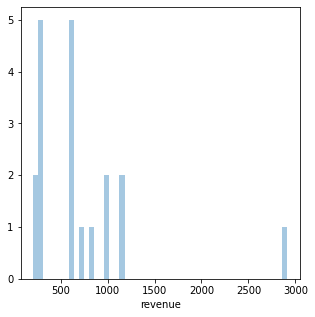

In [80]:
plt.figure(figsize = (5,5))
sns.distplot(rus_android_A[rus_android_A.revenue>0].revenue, kde=False, bins=50)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


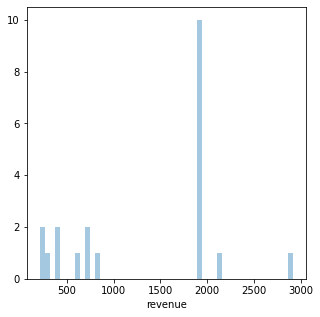

In [81]:
plt.figure(figsize = (5,5))
sns.distplot(rus_android_B_1[rus_android_B_1.revenue>0].revenue, kde=False, bins=50)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


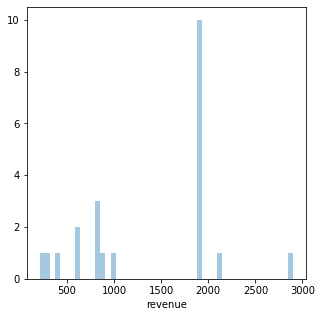

In [82]:
plt.figure(figsize = (5,5))
sns.distplot(rus_android_B_2[rus_android_B_2.revenue>0].revenue, kde=False, bins=50)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


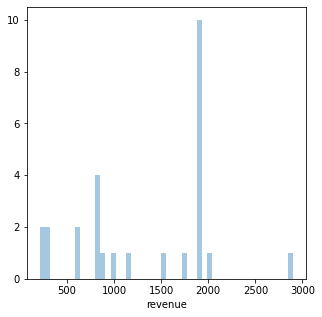

In [83]:
plt.figure(figsize = (5,5))
sns.distplot(rus_android_B_3[rus_android_B_3.revenue>0].revenue, kde=False, bins=50)

In [84]:
#критических выборосов не обнаружено

In [85]:
#применим стат метод bootstrap. 

In [86]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

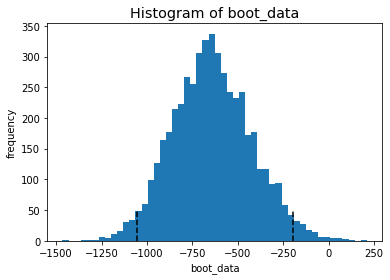

{'boot_data': [-479.6190476190476,
  -742.6190476190476,
  -568.0,
  -677.1904761904761,
  -839.4285714285714,
  -482.1904761904762,
  -405.6190476190476,
  -268.14285714285717,
  -790.0952380952381,
  -855.047619047619,
  -84.66666666666667,
  -815.952380952381,
  -831.5238095238095,
  -562.0952380952381,
  -270.7142857142857,
  -695.0,
  -814.8571428571429,
  -515.9047619047619,
  -561.8095238095239,
  -816.8571428571429,
  -345.0,
  -524.4285714285714,
  -1028.5238095238096,
  -733.6190476190476,
  -569.4761904761905,
  -1033.7142857142858,
  -861.7142857142857,
  -584.6666666666666,
  -160.61904761904762,
  -780.7619047619048,
  -918.4285714285714,
  -455.76190476190476,
  -536.6666666666666,
  -772.0,
  -746.952380952381,
  -638.6666666666666,
  -543.952380952381,
  -603.6190476190476,
  -947.8571428571429,
  -470.3809523809524,
  -367.14285714285717,
  -741.8095238095239,
  -463.04761904761904,
  -705.8571428571429,
  -813.4761904761905,
  -471.04761904761904,
  -692.095238095238

In [87]:
booted_data = get_bootstrap(rus_android_A[rus_android_A.revenue>0].revenue, rus_android_B_1[rus_android_B_1.revenue>0].revenue, boot_it = 5000) # в результате хранится разница двух распределений, ДИ и pvalue
booted_data

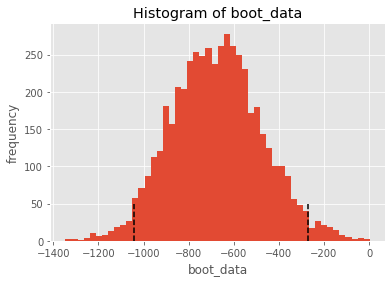

{'boot_data': [-621.2272727272727,
  -759.0,
  -662.0909090909091,
  -602.5909090909091,
  -553.3181818181819,
  -1129.409090909091,
  -658.7727272727273,
  -794.3636363636364,
  -758.1818181818181,
  -917.6363636363636,
  -981.2272727272727,
  -293.3636363636364,
  -708.3181818181819,
  -678.7272727272727,
  -864.0,
  -717.1818181818181,
  -736.2272727272727,
  -759.4545454545455,
  -752.3181818181819,
  -285.3636363636364,
  -666.2727272727273,
  -624.7272727272727,
  -956.5909090909091,
  -856.1363636363636,
  -562.9545454545455,
  -885.8636363636364,
  -625.9545454545455,
  -549.9545454545455,
  -518.9090909090909,
  -377.3181818181818,
  -798.9545454545455,
  -585.4090909090909,
  -447.6818181818182,
  -577.5454545454545,
  -848.6818181818181,
  -690.3181818181819,
  -574.3181818181819,
  -949.0454545454545,
  -615.0454545454545,
  -603.6363636363636,
  -1101.2727272727273,
  -716.9090909090909,
  -799.8181818181819,
  -476.04545454545456,
  -859.6363636363636,
  -821.272727272727

In [88]:
booted_data = get_bootstrap(rus_android_A[rus_android_A.revenue>0].revenue, rus_android_B_2[rus_android_B_2.revenue>0].revenue, boot_it = 5000) # в результате хранится разница двух распределений, ДИ и pvalue
booted_data

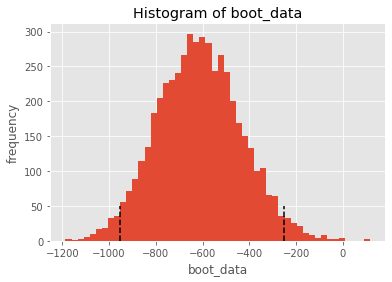

{'boot_data': [-538.4444444444445,
  -584.925925925926,
  -466.77777777777777,
  -623.7407407407408,
  -429.85185185185185,
  -643.1851851851852,
  -293.55555555555554,
  -486.14814814814815,
  -822.0,
  -491.0,
  -352.0740740740741,
  -673.3333333333334,
  -587.1111111111111,
  -535.3703703703703,
  -772.2222222222222,
  -347.962962962963,
  -505.5925925925926,
  -283.44444444444446,
  -948.2962962962963,
  -624.5555555555555,
  -806.3333333333334,
  -611.2962962962963,
  -784.1111111111111,
  -495.48148148148147,
  -593.074074074074,
  -780.0,
  -510.2962962962963,
  -506.25925925925924,
  -672.3333333333334,
  -693.1851851851852,
  -912.6666666666666,
  -405.5925925925926,
  -729.5555555555555,
  -424.0,
  -650.4814814814815,
  -576.8888888888889,
  -859.1111111111111,
  -622.7777777777778,
  -332.1111111111111,
  -378.18518518518516,
  -470.9259259259259,
  -882.5555555555555,
  -771.3333333333334,
  -676.5925925925926,
  -782.074074074074,
  -651.1481481481482,
  -922.259259259259

In [89]:
booted_data = get_bootstrap(rus_android_A[rus_android_A.revenue>0].revenue, rus_android_B_3[rus_android_B_3.revenue>0].revenue, boot_it = 5000) # в результате хранится разница двух распределений, ДИ и pvalue
booted_data

Виден статистически значимый рост среднего чека с уровнем значимости 0.95 для каждой из тестовых групп. Для каждой из сэмплированных выборок pvalue получился ниже 0.01, а значит и суммарная вероятность полученная из перемножения вероятностей существования стат значимых отличий для каждой тестовой группы однозначно ниже порога в 0.95.

### Анализ отклонений конверсии в покупку

In [90]:
#теперь оценим если ли отличия в конверсии в покупку новых шаблонов. Применим тот же A/B_1/B_2/B_3 тест 

In [91]:
conv_A=rus_android_A.conv_value
conv_B_1=rus_android_B_1.conv_value
conv_B_2=rus_android_B_2.conv_value
conv_B_3=rus_android_B_3.conv_value

In [92]:
#сперва оценим отклонения стат методом bootstrap

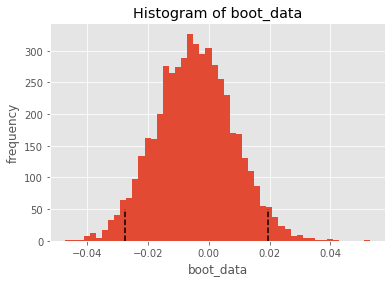

{'boot_data': [0.00196078431372549,
  -0.013725490196078431,
  0.01568627450980392,
  -0.00196078431372549,
  -0.029411764705882353,
  -0.013725490196078431,
  -0.00784313725490196,
  -0.013725490196078431,
  0.00392156862745098,
  -0.011764705882352941,
  -0.027450980392156862,
  -0.023529411764705882,
  0.01764705882352941,
  0.0,
  -0.00784313725490196,
  -0.00196078431372549,
  -0.03137254901960784,
  -0.011764705882352941,
  -0.023529411764705882,
  -0.029411764705882353,
  -0.013725490196078431,
  0.00392156862745098,
  -0.025490196078431372,
  0.00980392156862745,
  -0.0058823529411764705,
  -0.023529411764705882,
  0.00196078431372549,
  -0.027450980392156862,
  -0.00392156862745098,
  -0.013725490196078431,
  0.01764705882352941,
  -0.00784313725490196,
  -0.01764705882352941,
  -0.01568627450980392,
  -0.025490196078431372,
  0.0,
  -0.00784313725490196,
  -0.00392156862745098,
  -0.013725490196078431,
  -0.013725490196078431,
  0.00196078431372549,
  -0.0058823529411764705,


In [93]:
booted_data = get_bootstrap(conv_A, conv_B_1, boot_it = 5000) # в результате хранится разница двух распределений, ДИ и pvalue
booted_data

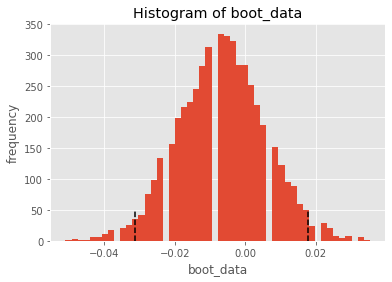

{'boot_data': [-0.01764705882352941,
  -0.0058823529411764705,
  -0.00392156862745098,
  -0.027450980392156862,
  0.00980392156862745,
  0.00196078431372549,
  -0.0058823529411764705,
  -0.0058823529411764705,
  0.00392156862745098,
  -0.0196078431372549,
  0.00392156862745098,
  -0.023529411764705882,
  0.00392156862745098,
  0.00196078431372549,
  -0.00196078431372549,
  -0.011764705882352941,
  0.013725490196078431,
  -0.01568627450980392,
  -0.013725490196078431,
  0.00392156862745098,
  -0.01764705882352941,
  0.00196078431372549,
  -0.00980392156862745,
  -0.0196078431372549,
  -0.0196078431372549,
  -0.0058823529411764705,
  -0.00784313725490196,
  0.023529411764705882,
  0.0,
  -0.0058823529411764705,
  -0.03137254901960784,
  -0.00784313725490196,
  -0.0058823529411764705,
  0.00980392156862745,
  -0.013725490196078431,
  -0.00980392156862745,
  0.00196078431372549,
  -0.00784313725490196,
  0.011764705882352941,
  0.0,
  -0.00980392156862745,
  -0.03725490196078431,
  -0.0117

In [94]:
booted_data = get_bootstrap(conv_A, conv_B_2, boot_it = 5000) # в результате хранится разница двух распределений, ДИ и pvalue
booted_data

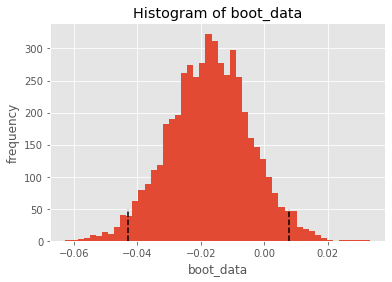

{'boot_data': [-0.0196078431372549,
  -0.00784313725490196,
  -0.00784313725490196,
  0.00980392156862745,
  -0.00392156862745098,
  -0.00392156862745098,
  -0.01568627450980392,
  -0.011764705882352941,
  -0.00196078431372549,
  -0.027450980392156862,
  -0.01764705882352941,
  -0.00980392156862745,
  -0.021568627450980392,
  -0.00392156862745098,
  -0.03137254901960784,
  -0.0058823529411764705,
  -0.00980392156862745,
  -0.03529411764705882,
  -0.03333333333333333,
  -0.01764705882352941,
  -0.0196078431372549,
  -0.01568627450980392,
  -0.023529411764705882,
  -0.021568627450980392,
  -0.03137254901960784,
  -0.03137254901960784,
  -0.029411764705882353,
  -0.011764705882352941,
  -0.0196078431372549,
  -0.013725490196078431,
  -0.03137254901960784,
  -0.013725490196078431,
  0.0,
  -0.03333333333333333,
  -0.00784313725490196,
  -0.00980392156862745,
  -0.01568627450980392,
  -0.0058823529411764705,
  -0.03333333333333333,
  -0.01568627450980392,
  -0.03137254901960784,
  -0.013725

In [95]:
booted_data = get_bootstrap(conv_A, conv_B_3, boot_it = 5000) # в результате хранится разница двух распределений, ДИ и pvalue
booted_data

In [96]:
#проверим конверсию методом Хи-квадрат
#сперва получим конверсию для объединенных датафреймов df_AB_1,df_AB_2 и df_AB_3

In [97]:
rus_android_AB_1 = df_AB_1[(df_AB_1.country == 'Russia') & (df_AB_1.platform == 'android')]
rus_android_AB_2 = df_AB_2[(df_AB_2.country == 'Russia') & (df_AB_2.platform == 'android')]
rus_android_AB_3 = df_AB_3[(df_AB_3.country == 'Russia') & (df_AB_3.platform == 'android')]

In [98]:
#конверсия для df_AB_1
conv_1=rus_android_AB_1.groupby('group',as_index=False).agg({'user_id':'count','conv_value':'sum'})
conv_1['convertion']=round(conv_1.conv_value/conv_1.user_id *100,2)
conv_1

,group,user_id,conv_value,convertion
0,A,510,19,3.73
1,B,502,21,4.18


In [99]:
#конверсия для df_AB_2
conv_2=rus_android_AB_2.groupby('group',as_index=False).agg({'user_id':'count','conv_value':'sum'})
conv_2['convertion']=round(conv_2.conv_value/conv_2.user_id *100,2)
conv_2

,group,user_id,conv_value,convertion
0,A,510,19,3.73
1,B,503,22,4.37


In [100]:
#конверсия для df_AB_3
conv_3=rus_android_AB_3.groupby('group',as_index=False).agg({'user_id':'count','conv_value':'sum'})
conv_3['convertion']=round(conv_3.conv_value/conv_3.user_id *100,2)
conv_3

,group,user_id,conv_value,convertion
0,A,510,19,3.73
1,B,493,27,5.48


In [101]:
import statsmodels.stats.proportion as proportion

In [102]:
#proportion.proportions_chisquare

In [103]:
chi2stat, pval1, table = proportion.proportions_chisquare(conv_1.conv_value, conv_1.user_id)
print(f'pval1 = {round(pval1,2)}, что больше уровня значимости alpha = 0.05, не можем отклонить H0')

pval1 = 0.71, что больше уровня значимости alpha = 0.05, не можем отклонить H0


In [104]:
chi2stat, pval2, table = proportion.proportions_chisquare(conv_2.conv_value, conv_2.user_id)
print(f'pval2 = {round(pval2,2)}, что больше уровня значимости alpha = 0.05, не можем отклонить H0')

pval2 = 0.6, что больше уровня значимости alpha = 0.05, не можем отклонить H0


In [105]:
chi2stat, pval3, table = proportion.proportions_chisquare(conv_3.conv_value, conv_3.user_id)
print(f'pval3 = {round(pval3,2)}, что больше уровня значимости alpha = 0.05, не можем отклонить H0')

pval3 = 0.19, что больше уровня значимости alpha = 0.05, не можем отклонить H0


Получается для трех вариантов тестовой выборки отклонить нулевую гипотезу не получится. Примечательно, что стат метод bootstrap показал схожие результаты с методом Хи-квадрат.
Но теперь хотелось бы узнать, были ли у нас вообще шансы увидеть стат значимую разницу в конверсии. Для этого оценим мощность нашего теста.

Оценка мощности теста

In [106]:
import statsmodels.stats.power as smp

In [107]:
chipower=smp.GofChisquarePower()
#??chipower.solve_power

In [108]:
convertion_A=conv_1.convertion.values[0]/100

#для тестовой сплит группы B_1
convertion_B_1=conv_1.convertion.values[1]/100
nobs_1=min(conv_1.user_id)

#для тестовой сплит группы B_2
convertion_B_2=conv_2.convertion.values[1]/100
nobs_2=min(conv_2.user_id)

#для тестовой сплит группы B_3
convertion_B_3=conv_3.convertion.values[1]/100
nobs_3=min(conv_3.user_id)

In [109]:
alpha=0.05

In [110]:
def chi2_effect_size(p0,p1):
    return np.sqrt(((p0-p1)**2/p0))

In [111]:
power_1=chipower.solve_power(effect_size = chi2_effect_size(convertion_A, convertion_B_1), nobs=nobs_1, alpha=pval1, power=None)
print(f'Мощность теста получилась равна {(round(power_1,3))*100}% при желаемой мощности 80% и выше')

Мощность теста получилась равна 74.4% при желаемой мощности 80% и выше


In [112]:
power_2=chipower.solve_power(effect_size = chi2_effect_size(convertion_A, convertion_B_2), nobs=nobs_2, alpha=pval2, power=None)
print(f'Мощность теста получилась равна {(round(power_2,3))*100}% при желаемой мощности 80% и выше')

Мощность теста получилась равна 69.0% при желаемой мощности 80% и выше


In [113]:
power_3=chipower.solve_power(effect_size = chi2_effect_size(convertion_A, convertion_B_3), nobs=nobs_3, alpha=pval3, power=None)
print(f'Мощность теста получилась равна {(round(power_3,3))*100}% при желаемой мощности 80% и выше')

Мощность теста получилась равна 75.4% при желаемой мощности 80% и выше


In [114]:
#Вычислим количество наблюдений, необходимых для получения желаемого уровня мощности

In [115]:
power=0.8

In [116]:
size_of_test_group_1=chipower.solve_power(effect_size = chi2_effect_size(convertion_A, convertion_B_1), nobs=None, alpha=alpha, power=power)
print('Необходимый размер контрольной и тестовой выборки:', round(2*size_of_test_group_1,0))

Необходимый размер контрольной и тестовой выборки: 28915.0


In [117]:
size_of_test_group_2=chipower.solve_power(effect_size = chi2_effect_size(convertion_A, convertion_B_2), nobs=None, alpha=alpha, power=power)
print('Необходимый размер контрольной и тестовой выборки:', round(2*size_of_test_group_2,0))

Необходимый размер контрольной и тестовой выборки: 14295.0


In [118]:
size_of_test_group_3=chipower.solve_power(effect_size = chi2_effect_size(convertion_A, convertion_B_3), nobs=None, alpha=alpha, power=power)
print('Необходимый размер контрольной и тестовой выборки:', round(2*size_of_test_group_3,0))

Необходимый размер контрольной и тестовой выборки: 1912.0


In [119]:
#попробую оценить влияние на общую выручку от изменения среднего чека и конверсии
revenue_A=rus_android_A[rus_android_A.revenue>0].user_id.count()*rus_android_A[rus_android_A.revenue>0].revenue.mean()
revenue_B_1=rus_android_A[rus_android_A.revenue>0].user_id.count()*rus_android_B_1[rus_android_B_1.revenue>0].revenue.mean()
revenue_B_2=rus_android_A[rus_android_A.revenue>0].user_id.count()*rus_android_B_2[rus_android_B_2.revenue>0].revenue.mean()
revenue_B_3=rus_android_A[rus_android_A.revenue>0].user_id.count()*rus_android_B_3[rus_android_B_3.revenue>0].revenue.mean()
(revenue_B_1+revenue_B_2+revenue_B_3)/3/revenue_A

1.8914864686957598

Таким образом для контрольной группы Russia на android необходимо увеличить конверсию в 1.9 раза (или на 90%), чтобы выручка от этого эффекта при том же среднем чеке была равна выручке от увеличения среднего чека, полученной для тестовых групп (усредненный) при уровне конверсии контрольной группы.
Или же конверсия должна упасть почти в 1.9 раза чтобы нивелировать эффект от увеличения среднего чека.

**Вывод по пользователям категори Russian на android:** 

Невозможность статистически подтвердить рост конверсии из-за небольшой выборки и/или недостаточно высокого уровня роста конверсии тестовых групп не дают нам статистически уверенно сказать, что пользователи из Russia на платформе android стали чаще приобретать шаблоны. 

Однако статистически подтвержденный рост среднего чека для этой категории все же дает нам надежду на успешное внедрение новой системы оплаты шаблонов для пользователей из Russia на платформе android.

Для однозначных статистических выводов рекомендуется увеличить длительность A/B теста и разобраться с ситемой сплитования и/или факторами мешающим репрезентативности контрольной и тестовой выборок.

Поскольку рост среднего чека вышел значительным и статистически доказанным, а конверсия в покупку шаблона крайне маловероятно что может упасть в 1.9 раза чтобы нивелировать эффект от роста среднего чека, то даже на этих данных с высокой вероятностью стоит рекомендовать внедрить новую систему оплаты шаблонов для этой группы пользователей.

### Статистический анализ отклонений средних чеков и конверсии для контрольной и тестовых групп пользователей - *Sweden* на *ios*

In [120]:
#сперва оценим распределение чеков на предмет явных выбросов

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


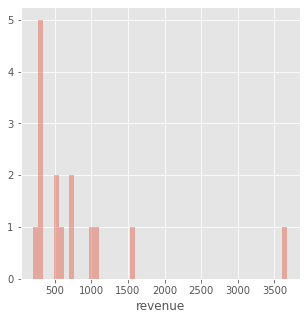

In [121]:
plt.figure(figsize = (5,5))
sns.distplot(swe_ios_A[swe_ios_A.revenue>0].revenue, kde=False, bins=50)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


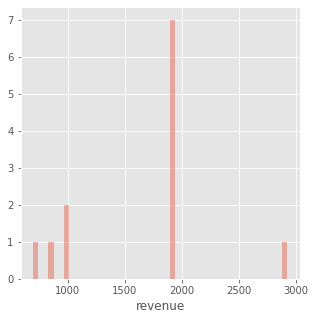

In [122]:
plt.figure(figsize = (5,5))
sns.distplot(swe_ios_B_1[swe_ios_B_1.revenue>0].revenue, kde=False, bins=50)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


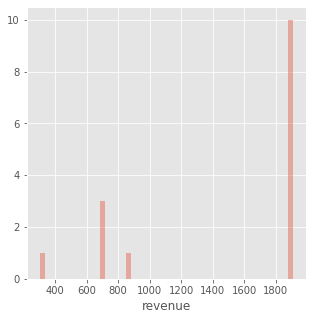

In [123]:
plt.figure(figsize = (5,5))
sns.distplot(swe_ios_B_2[swe_ios_B_2.revenue>0].revenue, kde=False, bins=50)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


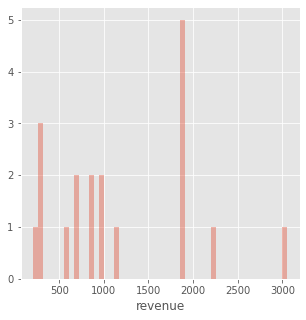

In [124]:
plt.figure(figsize = (5,5))
sns.distplot(swe_ios_B_3[swe_ios_B_3.revenue>0].revenue, kde=False, bins=50)

In [125]:
#применим стат метод bootstrap для средних чеков

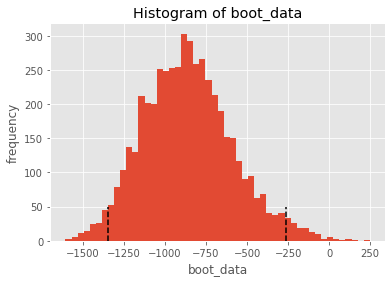

{'boot_data': [-200.26666666666668,
  -1047.6666666666667,
  6.466666666666667,
  -646.5333333333333,
  -605.4666666666667,
  -1141.0666666666666,
  -969.1333333333333,
  -1236.1333333333334,
  -573.1333333333333,
  -1201.0666666666666,
  -1360.8666666666666,
  -1048.2666666666667,
  -766.6666666666666,
  -968.8,
  -818.3333333333334,
  -621.2,
  -834.2,
  -1079.6666666666667,
  -1213.0,
  -682.4,
  -1120.0,
  -388.73333333333335,
  -487.8,
  131.8,
  -807.3333333333334,
  -637.6666666666666,
  -775.4666666666667,
  -1326.7333333333333,
  -779.1333333333333,
  -942.0,
  -1201.7333333333333,
  -651.6666666666666,
  -1391.4666666666667,
  -1147.1333333333334,
  -740.7333333333333,
  -1313.4666666666667,
  -999.9333333333333,
  -821.1333333333333,
  -1267.9333333333334,
  -740.8,
  -734.6,
  -1114.5333333333333,
  -526.1333333333333,
  -877.0,
  -401.1333333333333,
  -594.6,
  -406.2,
  -469.0,
  -1025.0666666666666,
  -1010.6,
  -1152.0,
  -1161.0,
  -781.1333333333333,
  -625.4666666666

In [126]:
booted_data = get_bootstrap(swe_ios_A[swe_ios_A.revenue>0].revenue, swe_ios_B_1[swe_ios_B_1.revenue>0].revenue, boot_it = 5000) # в результате хранится разница двух распределений, ДИ и pvalue
booted_data

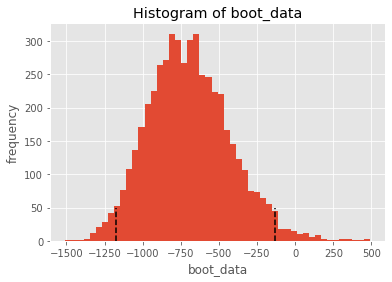

{'boot_data': [-908.4,
  -369.1333333333333,
  -1317.3333333333333,
  -226.06666666666666,
  -656.7333333333333,
  -702.6666666666666,
  -724.8666666666667,
  -382.06666666666666,
  -1114.6,
  -766.4666666666667,
  -395.1333333333333,
  -466.1333333333333,
  -987.5333333333333,
  -539.4,
  -1081.2,
  -545.4666666666667,
  -903.9333333333333,
  -1247.2,
  -379.2,
  -784.0666666666667,
  -939.7333333333333,
  -482.46666666666664,
  -896.9333333333333,
  -271.53333333333336,
  -671.2666666666667,
  -638.6666666666666,
  -366.1333333333333,
  -900.0,
  -711.6,
  -861.2666666666667,
  -1035.0,
  -291.26666666666665,
  -821.1333333333333,
  -747.2,
  -1119.6666666666667,
  -563.7333333333333,
  -839.0666666666667,
  -744.3333333333334,
  -1030.4666666666667,
  -579.0,
  -642.4666666666667,
  -950.0,
  -453.1333333333333,
  -427.6666666666667,
  -1150.2666666666667,
  -823.6,
  -1278.1333333333334,
  -398.93333333333334,
  -981.1333333333333,
  -356.8,
  -638.6,
  -380.4,
  -623.5333333333333

In [127]:
booted_data = get_bootstrap(swe_ios_A[swe_ios_A.revenue>0].revenue, swe_ios_B_2[swe_ios_B_2.revenue>0].revenue, boot_it = 5000) # в результате хранится разница двух распределений, ДИ и pvalue
booted_data

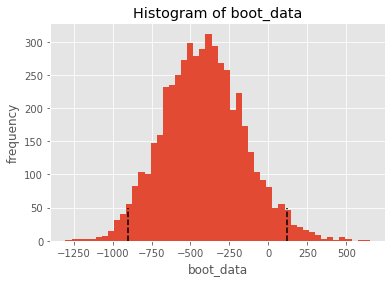

{'boot_data': [-57.0,
  -526.8947368421053,
  -1017.1052631578947,
  -890.6315789473684,
  -173.78947368421052,
  -215.52631578947367,
  -719.8947368421053,
  -714.8947368421053,
  487.10526315789474,
  -725.7368421052631,
  -151.31578947368422,
  -633.1052631578947,
  -461.05263157894734,
  -591.3684210526316,
  -331.94736842105266,
  -178.89473684210526,
  -536.5263157894736,
  -135.1578947368421,
  329.5263157894737,
  -269.1578947368421,
  -603.578947368421,
  -189.68421052631578,
  -212.0,
  -361.42105263157896,
  -196.78947368421052,
  -109.94736842105263,
  -527.7368421052631,
  -457.3157894736842,
  -591.1052631578947,
  -305.0,
  -250.21052631578948,
  -767.0526315789474,
  -488.3157894736842,
  -476.7368421052632,
  -569.578947368421,
  -423.05263157894734,
  -273.8421052631579,
  -396.8421052631579,
  -435.2631578947368,
  -304.36842105263156,
  -142.3684210526316,
  -308.42105263157896,
  -556.421052631579,
  -421.2105263157895,
  -646.3157894736842,
  -667.3684210526316,
 

In [128]:
booted_data = get_bootstrap(swe_ios_A[swe_ios_A.revenue>0].revenue, swe_ios_B_3[swe_ios_B_3.revenue>0].revenue, boot_it = 5000) # в результате хранится разница двух распределений, ДИ и pvalue
booted_data

Вывод:

2 из 3 выборки показали уверенные стат различимые отличия у контрольной и тестовых групп. 3я выборка имеет спорные стат значимые результаты, и если перемножить вероятности стат значимых отличий для всех тестовых групп, то суммарная вероятность получилась ниже 0.95.

In [129]:
#проверим конверсию методом Хи-квадрат

In [130]:
swe_ios_AB_1 = df_AB_1[(df_AB_1.country == 'Sweden') & (df_AB_1.platform == 'ios')]
swe_ios_AB_2 = df_AB_2[(df_AB_2.country == 'Sweden') & (df_AB_2.platform == 'ios')]
swe_ios_AB_3 = df_AB_3[(df_AB_3.country == 'Sweden') & (df_AB_3.platform == 'ios')]

In [131]:
#конверсия для df_AB_1
conv_swe_ios_1=swe_ios_AB_1.groupby('group',as_index=False).agg({'user_id':'count','conv_value':'sum'})
conv_swe_ios_1['convertion']=round(conv_swe_ios_1.conv_value/conv_swe_ios_1.user_id *100,2)
conv_swe_ios_1

,group,user_id,conv_value,convertion
0,A,299,15,5.02
1,B,275,12,4.36


In [132]:
#конверсия для df_AB_2
conv_swe_ios_2=swe_ios_AB_2.groupby('group',as_index=False).agg({'user_id':'count','conv_value':'sum'})
conv_swe_ios_2['convertion']=round(conv_swe_ios_2.conv_value/conv_swe_ios_2.user_id *100,2)
conv_swe_ios_2

,group,user_id,conv_value,convertion
0,A,299,15,5.02
1,B,290,15,5.17


In [133]:
#конверсия для df_AB_3
conv_swe_ios_3=swe_ios_AB_3.groupby('group',as_index=False).agg({'user_id':'count','conv_value':'sum'})
conv_swe_ios_3['convertion']=round(conv_swe_ios_3.conv_value/conv_swe_ios_3.user_id *100,2)
conv_swe_ios_3

,group,user_id,conv_value,convertion
0,A,299,15,5.02
1,B,259,19,7.34


In [134]:
chi2stat, pval1, table = proportion.proportions_chisquare(conv_swe_ios_1.conv_value, conv_swe_ios_1.user_id)
print(f'pval1 = {round(pval1,2)}, что больше уровня значимости alpha = 0.05, не можем отклонить H0')

pval1 = 0.71, что больше уровня значимости alpha = 0.05, не можем отклонить H0


In [135]:
chi2stat, pval2, table = proportion.proportions_chisquare(conv_swe_ios_2.conv_value, conv_swe_ios_2.user_id)
print(f'pval2 = {round(pval2,2)}, что больше уровня значимости alpha = 0.05, не можем отклонить H0')

pval2 = 0.93, что больше уровня значимости alpha = 0.05, не можем отклонить H0


In [136]:
chi2stat, pval3, table = proportion.proportions_chisquare(conv_swe_ios_3.conv_value, conv_swe_ios_3.user_id)
print(f'pval3 = {round(pval3,2)}, что больше уровня значимости alpha = 0.05, не можем отклонить H0')

pval3 = 0.25, что больше уровня значимости alpha = 0.05, не можем отклонить H0


Получается для трех вариантов тестовой выборки отклонить нулевую гипотезу не получится.
Теперь снова вычислим мощность и необходимый размер выборки для возможности произвести достоверный стат вывод.

In [137]:
convertion_A=conv_swe_ios_1.convertion.values[0]/100

#для тестовой сплит группы B_1
convertion_B_1=conv_swe_ios_1.convertion.values[1]/100
nobs_1=min(conv_swe_ios_1.user_id)

#для тестовой сплит группы B_2
convertion_B_2=conv_swe_ios_2.convertion.values[1]/100
nobs_2=min(conv_swe_ios_2.user_id)

#для тестовой сплит группы B_3
convertion_B_3=conv_swe_ios_3.convertion.values[1]/100
nobs_3=min(conv_swe_ios_3.user_id)

alpha=0.05

In [138]:
power_1=chipower.solve_power(effect_size = chi2_effect_size(convertion_A, convertion_B_1), nobs=nobs_1, alpha=pval1, power=None)
print(f'Мощность теста получилась равна {(round(power_1,3))*100}% при желаемой мощности 80% и выше')


Мощность теста получилась равна 74.3% при желаемой мощности 80% и выше


In [139]:
power_2=chipower.solve_power(effect_size = chi2_effect_size(convertion_A, convertion_B_2), nobs=nobs_2, alpha=pval2, power=None)
print(f'Мощность теста получилась равна {(round(power_2,3))*100}% при желаемой мощности 80% и выше')


Мощность теста получилась равна 93.2% при желаемой мощности 80% и выше


In [140]:
power_3=chipower.solve_power(effect_size = chi2_effect_size(convertion_A, convertion_B_3), nobs=nobs_3, alpha=pval3, power=None)
print(f'Мощность теста получилась равна {(round(power_3,3))*100}% при желаемой мощности 80% и выше')

Мощность теста получилась равна 70.19999999999999% при желаемой мощности 80% и выше


In [141]:
#Вычислим количество наблюдений, необходимых для получения желаемого уровня мощности

In [142]:
power=0.8

size_of_test_group_1=chipower.solve_power(effect_size = chi2_effect_size(convertion_A, convertion_B_1), nobs=None, alpha=alpha, power=power)
print('Необходимый размер контрольной и тестовой выборки:', round(2*size_of_test_group_1,0))

Необходимый размер контрольной и тестовой выборки: 18091.0


In [143]:
size_of_test_group_2=chipower.solve_power(effect_size = chi2_effect_size(convertion_A, convertion_B_2), nobs=None, alpha=alpha, power=power)
print('Необходимый размер контрольной и тестовой выборки:', round(2*size_of_test_group_2,0))

Необходимый размер контрольной и тестовой выборки: 350234.0


In [144]:
size_of_test_group_3=chipower.solve_power(effect_size = chi2_effect_size(convertion_A, convertion_B_3), nobs=None, alpha=alpha, power=power)
print('Необходимый размер контрольной и тестовой выборки:', round(2*size_of_test_group_3,0))

Необходимый размер контрольной и тестовой выборки: 1464.0


**Вывод по пользователям категори Sweden на ios:** 

Невозможность статистически подтвердить рост конверсии из-за небольшой выборки и/или недостаточно высокого уровня роста конверсии тестовых групп не дают нам статистически уверенно сказать, что пользователи из Russia на платформе android стали чаще приобретать шаблоны. 

Также невозможно статистически подтвердить рост среднего чека для этой категории, хотя тенденция к росту заметна.

Для однозначных статистических выводов рекомендуется увеличить длительность A/B теста и разобраться с ситемой сплитования и/или факторами мешающим репрезентативности контрольной и тестовой выборок.

### Статистический анализ отклонений средних чеков и конверсии для контрольной и тестовых групп пользователей - *Russia* на *ios*

Предыдущие два статистических исследования обладали более выраженными различиями в конверсии и средних чеках, и тем не менее статистически подвести итоги не удалось. Следовательно и для данной категории не получится сделать стат значимый вывод. 

Рекомендация ровно такая же, как и ранее - требуется увеличить длительность A/B теста и разобраться с системой сплитования и/или факторами мешающим репрезентативности контрольной и тестовой выборок.

## Общие выводы Задания 1:##

1) Изначально в данных А/B теста наблюдался весомый дисбаланс в тестовой и контрольной группе по категории стран (пользователей из России в тестовой группе стало больше в процентном соотношении, нежели в контрольной). Предположив что контрольная группа обладает репрезентативными данными (хотя вполне возможно именно тестовая группа получилась более репрезентативна к ГС), соответствующими тенденциям генеральной совокупости, и оценив разницу средних чеков и конверсии в этих странах, был сделан вывод о необходимости проведении повторного A/B теста с репрезентативными контрольной и тестовой группами. 

2) Было принято решение попробовать провести стат исследования с имеющимися данными. Для этого, исходя из того что контрольная группа репрезентативна, было проведено стратифицированное сэмплирование тестовой группы B для получения схожих пропорций по странам и другим категориальным параметрам как в группе А. Из этого были получены 3 варианта тестовых групп, каждая выборка которых совпадает по размеру с выборкой контрольной группы (что удобно для стат тестов).

3) Предварительный анализ тенденций роста среднего чека и конверсий между различными категориями пользователей приложения в рамках стран и платформ показал, что для пользователей из Russia на платформе android эти метрики растут, а для Sweden на ios наоброт падают и слишком рискованно внедрять новую систему для этой категории. Для Russia на ios и Sweden на android ситуация неоднозначна. 

4) Статистический анализ тенденций показал, что подтвердить рост конверсий для категорий выше невозможно ввиду маленькой выборки и/или невыского роста этой конверсии в тестовых группах. Статистически подтвердить рост среднего чека удалось только для пользователей Russia на android. 

5) Так же был проведен предварительный анализ тендеций по категориальным параметрам. Эти данные также можно оценить анализируя дэшборд Задания 2.

## Задание 2. ##

Одной из основных задач аналитика является не только построение моделей, но и создание дашбордов, которые позволяют отслеживать изменения метрик и принимать на их основе оптимальные решения. Ваш руководитель хочет узнать, как обстоят дела с использованием приложения и вовлечённостью пользователей, и очень просит спроектировать ему дашборд.

### Первые шаги: ###
Принято решение использовать изначальные данные по пользователям, категориям, и их тратам на покупку шаблонов как некие общие данные о продукте за интересующий нас период, хотя на мой взгляд это больше похоже на небольшой срез данных под конкретный A/B тест. На основании этих данных и будет построен дэшборд. При желании, пользователь сможет отфильтровать данные по конкретной А или B группе.

### Вывод информации ###
Ссылка на дэшборд:
https://public.tableau.com/app/profile/vladimir2144/viz/task_2_final_proj/Application_Dash?publish=yes